# Most common venues in German Cities

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

----

## Introduction: Business Problem <a name="introduction"></a>

This report is targeted to stakeholders who are interested in opening a restaurant in big city in Germany. 

The goal of this project is to analyse in **which city and what type of restaurant** has more chances to  succeed.

First we need to understand what are the most common venues in each city. In addition we would like to know the area and the number of inhabitants in each city. 
Knowing this information we can group the cities which have similar characteristics. Therefore, we can analyse each group to try to get insights or patterns to help us to draw our conclusions and suggestions to the stakeholders.

----

## Data <a name="data"></a>

The data we need must contain the following information:
* Name of the biggest cities in Germany 
* Number of the population per city
* Area in $km^2$ per city
* Latitude
* Longitude
* Name of the 10 most common venue per city

The data containing the first three itens from the list above is taken from  https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9Fst%C3%A4dte_in_Deutschland

The latitude and longitude values of the German cities is determined using the **Geopy Library**.

Finally, the most common venues of each city is obtained using **Foursquare API**

#### Importing the necessaries libraries:

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


The data containing the first three itens from the list above is taken from  https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9Fst%C3%A4dte_in_Deutschland

Notice that I download the file first and then read in a panda dataframe.

In [2]:
df = pd.read_csv(r'/Users/Molnar/Documents/GitHub/Capstone_Project/german_cities.txt', sep='\t')
df.head()

,City,Einwohnerzahl,Area_km2
0,Berlin,3669491,891.68
1,Hamburg,1847253,755.22
2,München,1484226,310.70
3,Köln,1087863,405.02
4,Frankfurt am Main,76338,248.31


The information about the population number and area of the cities can be condensate in only one variable that we call **density**.

In [3]:
df['density']=df['Einwohnerzahl']/df['Area_km2']
df.head()

,City,Einwohnerzahl,Area_km2,density
0,Berlin,3669491,891.68,4115.255473
1,Hamburg,1847253,755.22,2445.979979
2,München,1484226,310.70,4777.038944
3,Köln,1087863,405.02,2685.948842
4,Frankfurt am Main,76338,248.31,307.430228


Number of rows and columns in dataframe

In [4]:
df.shape

(80, 4)

#### Use geopy library to get the latitude and longitude values of the German cities

In [5]:
tab_list=[]
geolocator = Nominatim(user_agent="ny_explorer")
for x in df['City']:
    location = geolocator.geocode(x)
    latitude = location.latitude
    longitude = location.longitude
    tab_list.append([x,latitude,longitude])
    
#print(tab_list)
geo_df= pd.DataFrame(tab_list)
geo_df.columns = ['City', 
                  'Latitude', 
                  'Longitude']
geo_df.head()

,City,Latitude,Longitude
0,Berlin,52.517037,13.388860
1,Hamburg,53.550341,10.000654
2,München,48.137108,11.575382
3,Köln,50.938361,6.959974
4,Frankfurt am Main,50.110644,8.682092


#### Merging the geografical coordenates with the original data.


In [6]:
df_cities=pd.merge(df, geo_df, on='City')
df_cities.head()

,City,Einwohnerzahl,Area_km2,density,Latitude,Longitude
0,Berlin,3669491,891.68,4115.255473,52.517037,13.388860
1,Hamburg,1847253,755.22,2445.979979,53.550341,10.000654
2,München,1484226,310.70,4777.038944,48.137108,11.575382
3,Köln,1087863,405.02,2685.948842,50.938361,6.959974
4,Frankfurt am Main,76338,248.31,307.430228,50.110644,8.682092


-----

## Methodology

We use the folium library to create the geografical map of Germany.

We select the Kassel city as the central location in our map. 

In [7]:
address = 'Kassel'

#geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Germany are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Germany are 51.3154546, 9.4924096.


#### Create a map of Germany with the main cities superimposed on top.

In [8]:
# create map of New York using latitude and longitude values
map_germany = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, city in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_germany)  
    
map_germany

Next, we are going to start utilizing the Foursquare API to explore the venues of each city and segment them.


#### Define Foursquare Credentials and Version


In [10]:
CLIENT_ID = '1D114MHX1AKEDV2IES4CNIRIZ14C133A3AJBDURN12BLR3F0' # your Foursquare ID
CLIENT_SECRET = 'PWVKDM00KHNS4SVJ2UQDKYDSAIBGAUVWTMUYLJCLVHWN3INC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Let's explore the first neighborhood in our dataframe.


Get the neighborhood's name.


In [11]:
df_cities.loc[0, 'City']

'Berlin'

Get the neighborhood's latitude and longitude values.


In [12]:
city_latitude = df_cities.loc[0, 'Latitude'] # latitude value
city_longitude = df_cities.loc[0, 'Longitude'] # longitude value

city_name = df_cities.loc[0, 'City'] # name

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

Latitude and longitude values of Berlin are 52.5170365, 13.3888599.


First, let's create the GET request URL. Name your URL **url**.


In [14]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT)

In [15]:
results = requests.get(url).json()

All the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-17-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Dussmann English Bookshop,Bookstore,52.518223,13.389239
1,Dussmann das KulturKaufhaus,Bookstore,52.518312,13.388708
2,Freundschaft,Wine Bar,52.518294,13.390344
3,Cookies Cream,Vegetarian / Vegan Restaurant,52.516569,13.388008
4,Komische Oper,Opera House,52.515968,13.386701


And how many venues were returned by Foursquare?


In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

73 venues were returned by Foursquare.


<a id='item2'></a>


#### Exploring the cities


#### Let's create a function to repeat the same process to all the main cities in Germany


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Running the function above on each city and create a new dataframe called _cities_venues_.


In [20]:
cities_venues = getNearbyVenues(names=df_cities['City'],
                                   latitudes=df_cities['Latitude'],
                                   longitudes=df_cities['Longitude']
                                  )


Berlin
Hamburg
München
Köln
Frankfurt am Main
Stuttgart
Düsseldorf
Leipzig
Dortmund
Essen
Bremen
Dresden
Hannover
Nürnberg
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Münster
Karlsruhe
Mannheim
Augsburg
Wiesbaden
Mönchengladbach
Gelsenkirchen
Braunschweig
Aachen
Kiel
Chemnitz
Halle (Saale)
Magdeburg
Freiburg im Breisgau
Krefeld
Mainz
Lübeck
Erfurt
Oberhausen
Rostock
Kassel
Hagen
Saarbrücken
Potsdam
Hamm
Ludwigshafen am Rhein
Mülheim an der Ruhr
Oldenburg (Oldb)
Osnabrück
Leverkusen
Heidelberg
Darmstadt
Solingen
Herne
Neuss
Regensburg
Paderborn
Ingolstadt
Offenbach am Main
Fürth
Würzburg
Ulm
Heilbronn
Pforzheim
Wolfsburg
Göttingen
Bottrop
Reutlingen
Koblenz
Bremer­haven
Erlangen
Bergisch Gladbach
Trier
Recklinghausen
Jena
Remscheid
Moers
Siegen
Hildesheim
Gütersloh
Kaiserslautern


Size of the resulting dataframe


In [21]:
print(cities_venues.shape)
cities_venues.head()

(4293, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berlin,52.517037,13.38886,Dussmann English Bookshop,52.518223,13.389239,Bookstore
1,Berlin,52.517037,13.38886,Dussmann das KulturKaufhaus,52.518312,13.388708,Bookstore
2,Berlin,52.517037,13.38886,Freundschaft,52.518294,13.390344,Wine Bar
3,Berlin,52.517037,13.38886,Cookies Cream,52.516569,13.388008,Vegetarian / Vegan Restaurant
4,Berlin,52.517037,13.38886,Komische Oper,52.515968,13.386701,Opera House


Number of venues were returned for each city


In [22]:
cities_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Aachen,99,99,99,99,99,99
Augsburg,40,40,40,40,40,40
Bergisch Gladbach,24,24,24,24,24,24
Berlin,73,73,73,73,73,73
Bielefeld,55,55,55,55,55,55
Bochum,82,82,82,82,82,82
Bonn,86,86,86,86,86,86
Bottrop,16,16,16,16,16,16
Braunschweig,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues


In [23]:
print('There are {} uniques categories.'.format(len(cities_venues['Venue Category'].unique())))

There are 279 uniques categories.


<a id='item3'></a>


#### Analyze Each City


In [25]:
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['City'] = cities_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

And let's examine the new dataframe size.


In [26]:
cities_onehot.shape

(4293, 280)

#### Next, let's group rows by city and by taking the mean of the frequency of occurrence of each category


In [28]:
cities_grouped = cities_onehot.groupby('City').mean().reset_index()

#### Let's include the column with the density in dataframe


In [29]:
cities_grouped.shape
cities_grouped['density']=df_cities['density']

Let's write a function to sort the venues in descending order.


In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each city.


In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.drop(['density'], axis=1).iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,Drugstore,Sushi Restaurant,Plaza,Café,Ice Cream Shop,Bakery,Italian Restaurant,Hotel,Bar,Cocktail Bar
1,Augsburg,Plaza,Italian Restaurant,Bar,Café,Burger Joint,Historic Site,Indie Movie Theater,Falafel Restaurant,Farmers Market,Seafood Restaurant
2,Bergisch Gladbach,Café,Drugstore,Plaza,Clothing Store,Shopping Mall,Restaurant,Juice Bar,Liquor Store,Bank,Bakery
3,Berlin,German Restaurant,Hotel,Coffee Shop,Italian Restaurant,Wine Bar,Cocktail Bar,Concert Hall,Opera House,Clothing Store,Plaza
4,Bielefeld,Café,Mediterranean Restaurant,Coffee Shop,Clothing Store,Italian Restaurant,Steakhouse,Ice Cream Shop,Plaza,Bar,Restaurant


<a id='item4'></a>


#### Clustering the cities


We use all the venues obtained via API Foursquare and also the density to cluster the cities in specific groups.
Let's find first the best number of group based on the elbow method

In [32]:
cities_grouped_clustering = cities_grouped.drop('City', 1)

kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300,"random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cities_grouped_clustering)
    sse.append(kmeans.inertia_)

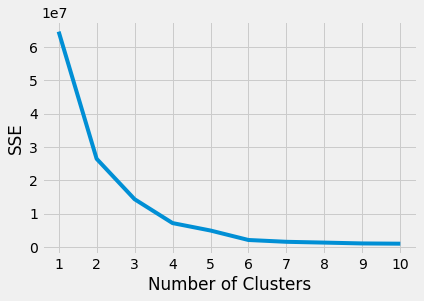

In [33]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The optimal group number is determined by the convexity of the curve above

In [34]:
#!conda install -c conda-forge folium=0.5.0 --yes 
#!conda install -c conda-forge kneed --yes 
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

In [35]:
# set number of clusters
kclusters = kl.elbow

cities_grouped_clustering = cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([3, 1, 3, 1, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 2, 1, 2, 0, 1,
       1, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

In [32]:
#cities_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each city in our original dataframe.


In [36]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = df_cities
# merge cities_grouped with df_cities to add latitude/longitude for each city
cities_merged = cities_merged.join(cities_venues_sorted.set_index('City'), on='City')

cities_merged.head() # check the last columns!

,City,Einwohnerzahl,Area_km2,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berlin,3669491,891.68,4115.255473,52.517037,13.388860,1,German Restaurant,Hotel,Coffee Shop,Italian Restaurant,Wine Bar,Cocktail Bar,Concert Hall,Opera House,Clothing Store,Plaza
1,Hamburg,1847253,755.22,2445.979979,53.550341,10.000654,1,Coffee Shop,Burger Joint,Café,Hotel,Italian Restaurant,Bar,Plaza,Cosmetics Shop,Vietnamese Restaurant,German Restaurant
2,München,1484226,310.70,4777.038944,48.137108,11.575382,1,Café,Bavarian Restaurant,Hotel,Plaza,German Restaurant,Coffee Shop,Department Store,Boutique,Clothing Store,Cocktail Bar
3,Köln,1087863,405.02,2685.948842,50.938361,6.959974,2,Plaza,Art Museum,Café,Bakery,Italian Restaurant,Brewery,Hotel,Pedestrian Plaza,Chinese Restaurant,Clothing Store
4,Frankfurt am Main,76338,248.31,307.430228,50.110644,8.682092,0,Café,Coffee Shop,Plaza,Burger Joint,Restaurant,Hotel,Art Museum,Department Store,Scenic Lookout,Bar


---


## Results and Discussion

In the code below we create the map of Germany with the city superimpoded on it. Notice that now the cities with the same color are in the same group.

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['City'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


#### Examine Clusters


#### Cluster 0


In [38]:
cities_merged.loc[cities_merged['Cluster Labels'] == 0, cities_merged.columns[[0] + list(range(3, cities_merged.shape[1]))]]

,City,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Frankfurt am Main,307.430228,50.110644,8.682092,0,Café,Coffee Shop,Plaza,Burger Joint,Restaurant,Hotel,Art Museum,Department Store,Scenic Lookout,Bar
6,Düsseldorf,2860.388207,51.225402,6.776314,0,Coffee Shop,Plaza,Boutique,Brewery,Italian Restaurant,Hotel,Café,German Restaurant,Bar,Clothing Store
8,Dortmund,209.557907,51.514227,7.465279,0,Café,Coffee Shop,Bakery,Plaza,Ice Cream Shop,Pizza Place,Hotel,Pub,Drugstore,Clothing Store
10,Bremen,1743.331490,53.075820,8.807165,0,German Restaurant,Café,Hotel,Italian Restaurant,Outdoor Sculpture,Asian Restaurant,Plaza,Drugstore,Burger Joint,Restaurant
13,Nürnberg,278.125335,49.453872,11.077298,0,Café,Bar,Italian Restaurant,Plaza,German Restaurant,Coffee Shop,Franconian Restaurant,Ice Cream Shop,Tapas Restaurant,Cocktail Bar
17,Bielefeld,1291.225562,52.019101,8.531007,0,Café,Mediterranean Restaurant,Coffee Shop,Clothing Store,Italian Restaurant,Steakhouse,Ice Cream Shop,Plaza,Bar,Restaurant
23,Wiesbaden,1365.537194,50.082038,8.241656,0,Plaza,Café,Hotel,Sushi Restaurant,Burger Joint,German Restaurant,Thai Restaurant,Theater,Seafood Restaurant,Falafel Restaurant
26,Braunschweig,1297.772921,52.264658,10.523607,0,Clothing Store,Italian Restaurant,Drugstore,Café,Plaza,Bar,Bakery,Supermarket,Hotel,Indian Restaurant
29,Chemnitz,1114.381362,50.832261,12.925298,0,Asian Restaurant,Clothing Store,Pub,Drugstore,Sushi Restaurant,Café,Electronics Store,Sporting Goods Shop,Bistro,Light Rail Station
30,Halle (Saale),1768.345430,51.482504,11.970545,0,Café,German Restaurant,Drugstore,Supermarket,Plaza,Clothing Store,Bar,Bakery,Historic Site,Indian Restaurant


In [43]:
cities_merged.loc[cities_merged['Cluster Labels'] == 0, cities_merged.columns[[0] + list(range(3, cities_merged.shape[1]))]].shape

(14, 15)

#### Cluster 1


In [40]:
cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[[0] + list(range(3, cities_merged.shape[1]))]]

,City,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berlin,4115.255473,52.517037,13.388860,1,German Restaurant,Hotel,Coffee Shop,Italian Restaurant,Wine Bar,Cocktail Bar,Concert Hall,Opera House,Clothing Store,Plaza
1,Hamburg,2445.979979,53.550341,10.000654,1,Coffee Shop,Burger Joint,Café,Hotel,Italian Restaurant,Bar,Plaza,Cosmetics Shop,Vietnamese Restaurant,German Restaurant
2,München,4777.038944,48.137108,11.575382,1,Café,Bavarian Restaurant,Hotel,Plaza,German Restaurant,Coffee Shop,Department Store,Boutique,Clothing Store,Cocktail Bar
7,Leipzig,1991.756212,51.340632,12.374733,1,Hotel,Plaza,Clothing Store,Bistro,Coffee Shop,Restaurant,Theater,Sushi Restaurant,Bagel Shop,Deli / Bodega
11,Dresden,169.501948,51.049329,13.738144,1,German Restaurant,Hotel,Café,Plaza,Italian Restaurant,Museum,Burger Joint,Art Museum,Historic Site,Ice Cream Shop
14,Duisburg,2142.121993,51.434999,6.759562,1,Café,Bakery,Butcher,Automotive Shop,Food Truck,Drugstore,Restaurant,Beer Garden,Shopping Mall,Brazilian Restaurant
15,Bochum,2509.865440,51.481811,7.219664,1,Bakery,Café,Ice Cream Shop,Drugstore,Bar,BBQ Joint,Restaurant,Soup Place,Burger Joint,Hookah Bar
18,Bonn,2337.111867,50.735851,7.100660,1,Plaza,Bar,Ice Cream Shop,German Restaurant,Italian Restaurant,Nightclub,Restaurant,Clothing Store,Hotel,Cocktail Bar
22,Augsburg,2019.763007,48.366804,10.898697,1,Plaza,Italian Restaurant,Bar,Café,Burger Joint,Historic Site,Indie Movie Theater,Falafel Restaurant,Farmers Market,Seafood Restaurant
24,Mönchengladbach,1531.260632,51.194698,6.435364,1,Clothing Store,German Restaurant,Sandwich Place,Drugstore,Café,Pizza Place,Bar,Sushi Restaurant,Supermarket,Restaurant


In [41]:
cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[[0] + list(range(3, cities_merged.shape[1]))]].shape

(22, 15)

#### Cluster 2


In [44]:
cities_merged.loc[cities_merged['Cluster Labels'] == 2, cities_merged.columns[[0] + list(range(3, cities_merged.shape[1]))]]

,City,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Köln,2685.948842,50.938361,6.959974,2,Plaza,Art Museum,Café,Bakery,Italian Restaurant,Brewery,Hotel,Pedestrian Plaza,Chinese Restaurant,Clothing Store
5,Stuttgart,3066.848324,48.778449,9.180013,2,German Restaurant,Plaza,Clothing Store,Theater,History Museum,Italian Restaurant,Coffee Shop,Café,Restaurant,Bar
9,Essen,277.056195,51.458224,7.015817,2,Nightclub,Pub,Plaza,Hotel,Clothing Store,Theater,Italian Restaurant,Fast Food Restaurant,Eastern European Restaurant,Performing Arts Venue
12,Hannover,2630.180268,52.374478,9.738553,2,Coffee Shop,Clothing Store,Italian Restaurant,Theater,Café,Burger Joint,Seafood Restaurant,Sushi Restaurant,Cocktail Bar,Plaza
16,Wuppertal,21.087951,51.264018,7.178037,2,Cable Car,River,Supermarket,Liquor Store,Burger Joint,Grilled Meat Restaurant,Gas Station,Women's Store,Dutch Restaurant,Drugstore
19,Münster,1039.610261,51.962510,7.625188,2,Café,Italian Restaurant,Bar,Plaza,German Restaurant,Ice Cream Shop,Gastropub,Bookstore,Pub,Hot Dog Joint
20,Karlsruhe,179.903148,49.006870,8.403420,2,Café,Coffee Shop,Plaza,Clothing Store,Bakery,Drugstore,German Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Pub
21,Mannheim,2143.060155,49.489591,8.467236,2,Café,Plaza,Hotel,Clothing Store,Korean Restaurant,Sushi Restaurant,Drugstore,Turkish Restaurant,Bar,Italian Restaurant
25,Gelsenkirchen,2474.223366,51.511032,7.096012,2,Drugstore,Ice Cream Shop,Clothing Store,Bus Stop,Supermarket,Sporting Goods Shop,Spanish Restaurant,Mexican Restaurant,Electronics Store,Eastern European Restaurant
28,Kiel,2080.016856,54.322708,10.135555,2,Coffee Shop,Drugstore,Clothing Store,Plaza,Café,Italian Restaurant,Fast Food Restaurant,Restaurant,German Restaurant,Cocktail Bar


In [45]:
cities_merged.loc[cities_merged['Cluster Labels'] == 2, cities_merged.columns[[0] + list(range(3, cities_merged.shape[1]))]].shape

(42, 15)

#### Cluster 3


In [46]:
cities_merged.loc[cities_merged['Cluster Labels'] == 3, cities_merged.columns[[0] + list(range(3, cities_merged.shape[1]))]]

,City,density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Aachen,154.777743,50.776351,6.083862,3,Drugstore,Sushi Restaurant,Plaza,Café,Ice Cream Shop,Bakery,Italian Restaurant,Hotel,Bar,Cocktail Bar
70,Bergisch Gladbach,1346.082561,50.992930,7.127738,3,Café,Drugstore,Plaza,Clothing Store,Shopping Mall,Restaurant,Juice Bar,Liquor Store,Bank,Bakery


We have used the k-means method to group the cities based on the common venues and the density of the population. 
Now we want to count the number of unique venues of each group. Notice that here the order of the most common are not necessary anymore.
To view better that we will make chart bars for each cluster.

The code below make a dataframe with the information for each group, how many times each venue appeared.

In [47]:
most_venues=cities_merged.columns[list(range(7, cities_merged.shape[1]))]
dfz = pd.DataFrame(columns=['Group',"unique_values", "counts"])
for k in range(kclusters):
    dfx = pd.DataFrame(columns=["unique_values", "counts"])
    for x in most_venues:
        dfy = cities_merged[x].loc[cities_merged['Cluster Labels'] == k].value_counts().rename_axis('unique_values').reset_index(name='counts')
        dfx=dfx.append(dfy)
    values_count = dfx.groupby(['unique_values'])['counts'].agg('sum').rename_axis('unique_values').reset_index(name='counts')
    #values_count.head()
    values_count['Group']=k
    dfz=dfz.append(values_count)
    
dfz.sort_values(by=['counts'],inplace=True)
dfz.head()

,Group,unique_values,counts
0,0,Art Museum,1
8,2,Betting Shop,1
10,2,Bistro,1
12,2,Breakfast Spot,1
16,2,Cable Car,1


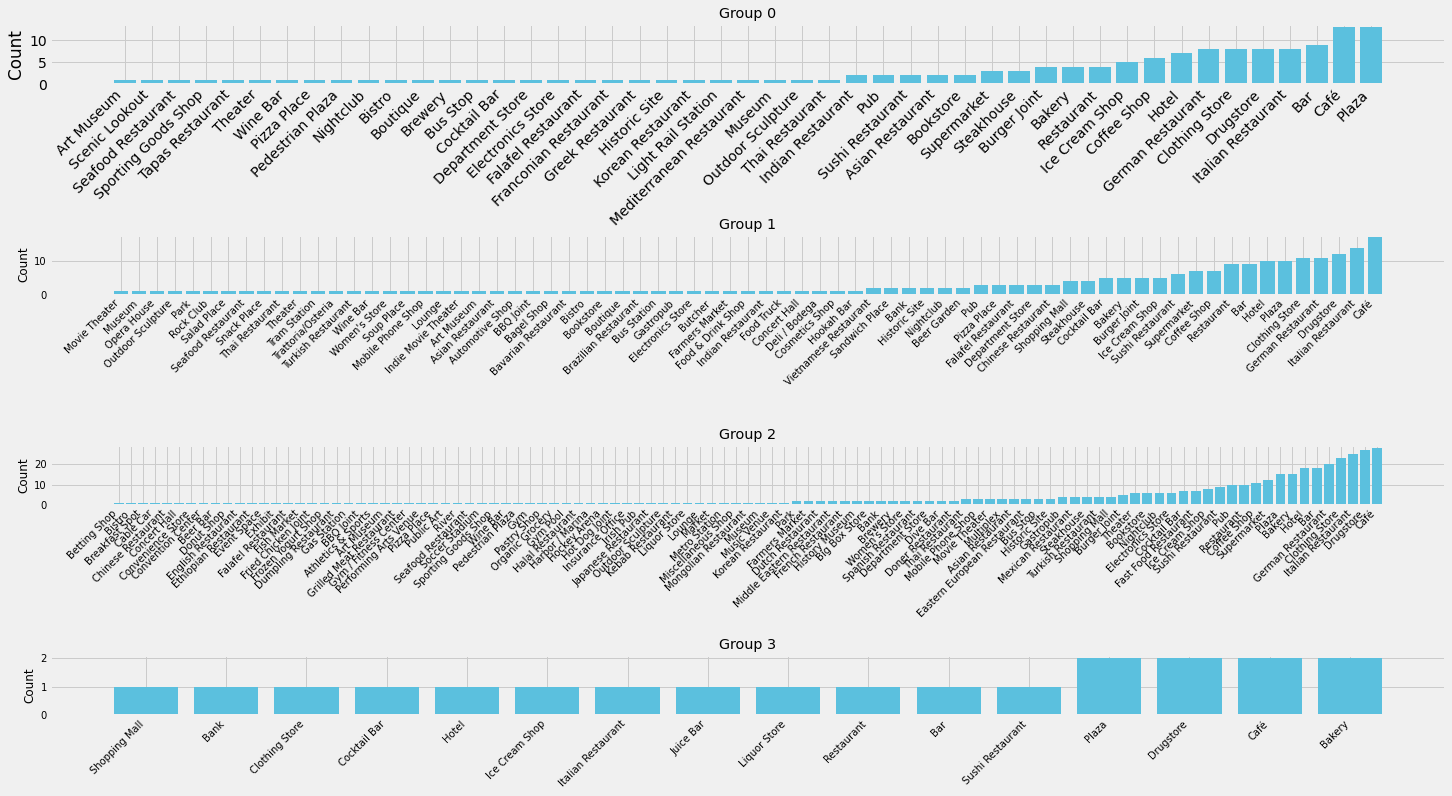

In [48]:
plt.figure(figsize=(25,12))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=2.5)

plt.subplot(411)
x = dfz['unique_values'].loc[dfz['Group']== 0]
count = dfz['counts'].loc[dfz['Group']== 0]

x_pos = [i for i, _ in enumerate(x)]

plt.rcParams.update({'font.size': 10})
plt.bar(x_pos, count, color='#5bc0de')
#plt.xlabel("Venue")
plt.ylabel("Count")
plt.title("Group 0")


plt.xticks(x_pos, x)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.subplot(412)

x = dfz['unique_values'].loc[dfz['Group']== 1]
count = dfz['counts'].loc[dfz['Group']== 1]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, count, color='#5bc0de')
#plt.xlabel("Venue")
plt.ylabel("Count")
plt.title("Group 1")


plt.xticks(x_pos, x)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.subplot(413)

x = dfz['unique_values'].loc[dfz['Group']== 2]
count = dfz['counts'].loc[dfz['Group']== 2]

x_pos = [i for i, _ in enumerate(x)]


plt.bar(x_pos, count, color='#5bc0de')
#plt.xlabel("Venue")
plt.ylabel("Count")
plt.title("Group 2")

plt.rcParams.update({'font.size': 10})
plt.xticks(x_pos, x)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.subplot(414)

x = dfz['unique_values'].loc[dfz['Group']== 3]
count = dfz['counts'].loc[dfz['Group']== 3]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, count, color='#5bc0de')
#plt.xlabel("Venue")
plt.ylabel("Count")
plt.title("Group 3")

plt.rcParams.update({'font.size': 10})
plt.xticks(x_pos, x)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

We can observe that the method k-means has created a group that has only two cities. However, still we can see that the most frequent venues are similar in each group.
Cafés, Italian and German restaurants are the most popular establishments, where one can sit and eat. Therefore, one can infer that these are safe options for venues to open in any German city.

We also notice that for group 2 Sushi restaurant appears with more frequency than in the others. Since the cities in the same group are similar, it could be a good insight to open a new sushi restaurant in cities from the same group which do not show the sushi restaurant in the 10 most common venues.

Analogously, we can sugggest to open a burger join in cities that do not have  it in the 10 most venues in the group 1.

In [104]:
#lista=lista=list()
#for x in cities_merged['City'].loc[cities_merged['Cluster Labels']==0]:
#    lista.append(x)
#print('Group 0: ', lista)

The code below indentify which city has the venue 'Sushi Restaurant' in the group 2.

In [51]:
df_gr2=cities_merged.loc[cities_merged['Cluster Labels']==2]
for x in most_venues:
    print(df_gr2['City'].loc[df_gr2[x]=='Sushi Restaurant'])

Series([], Name: City, dtype: object)
Series([], Name: City, dtype: object)
55    Paderborn
Name: City, dtype: object
Series([], Name: City, dtype: object)
63    Wolfsburg
71        Trier
Name: City, dtype: object
21    Mannheim
Name: City, dtype: object
Series([], Name: City, dtype: object)
12    Hannover
42     Potsdam
76      Siegen
Name: City, dtype: object
Series([], Name: City, dtype: object)
33                Krefeld
45    Mülheim an der Ruhr
Name: City, dtype: object


In [52]:
df_gr1=cities_merged.loc[cities_merged['Cluster Labels']==1]
for x in most_venues:
    print(df_gr1['City'].loc[df_gr1[x]=='Burger Joint'])

Series([], Name: City, dtype: object)
1    Hamburg
Name: City, dtype: object
Series([], Name: City, dtype: object)
Series([], Name: City, dtype: object)
22    Augsburg
Name: City, dtype: object
Series([], Name: City, dtype: object)
11    Dresden
Name: City, dtype: object
Series([], Name: City, dtype: object)
15            Bochum
79    Kaiserslautern
Name: City, dtype: object
Series([], Name: City, dtype: object)


---

## Conclusion

After analysing the data we have the following recomendations:
* Café, Italian and German restaurants are prefered by Germans. It is a safe and conservative option to open them in any city of Germany.
* A more bold but yet promising idea is to open a Sushi restaurant in cities from group 2, which do not have it in the 10 most frequent venues. 
* Analogously, it is possible to use the same argument to open a burger joint in cities from group 1. However, this is a risker option.